# ü©∫ Impact of Contraception on Lactobacillus Levels
### Investigating How Different Contraceptive Methods Affect the Vaginal Microbiome

---

## üìä Introduction
This analysis explores whether different **contraceptive methods** influence **Lactobacillus levels** in the vaginal microbiome.  

We classify **Lactobacillus levels into three categories**:  
- **Low (0)**  
- **Moderate (1)**  
- **High (2)**  

We examine:  
- **Group-level differences** using the **Kruskal-Wallis test and Dunn‚Äôs post-hoc test**.  
- **Correlation trends** using **Spearman‚Äôs correlation**.  
- **Logistic regression modeling** to estimate **odds ratios (OR) of having higher Lactobacillus levels**.  

---

## üìä Lactobacillus Classification Summary  
- **Total Participants:** **5,181**  
- **Lactobacillus Classification Breakdown:**  
  - **High (2):** **2,379 (46%)**  
  - **Moderate (1):** **1,457 (28%)**  
  - **Low (0):** **1,345 (26%)**  

Nearly **half of the participants have high Lactobacillus levels**, while **26% have low levels.**  
This suggests **substantial variation across the dataset.**  

---

To begin, we present two key visualizations:


### **üìä Proportion of Lactobacillus Classes per Contraceptive Group (Stacked Bar Chart)**

The stacked bar chart below illustrates the **proportion of low (0), intermediate (1), and high (2) Lactobacillus levels** across different contraceptive groups.

#### **Key Observations:**
- **Hormonal Coils** have the highest proportion of **low Lactobacillus levels**.
- **Condoms** show a higher percentage of **high Lactobacillus levels** compared to other methods.
- **Non-hormonal contraception and no contraception** have relatively balanced distributions.
- The results suggest **potential differences in Lactobacillus classification by contraceptive method**, warranting further statistical analysis.

In [67]:
import pandas as pd
import numpy as np
from scipy import stats
import scikit_posthocs as sp

# üìå Define file paths
file_path = "/Users/user/Documents/Business/Daye/DS/lb_hormonaltesting_obgyn_12022025/m-results-2025-02-12T13_01_02.609Z.csv"
contraception_file = "/Users/user/Documents/Business/Daye/DS/lb_hormonaltesting_obgyn_12022025/are-you-on-contraception_2025-02-12T13_36_03.168Z.csv"

# üìå Load datasets
raw_df = pd.read_csv(file_path)
contraception_df = pd.read_csv(contraception_file)

# üìå Ensure USER_ID column matches in name
contraception_df.rename(columns={'USER_ID': 'USERID'}, inplace=True)

# üìå Select necessary columns
df = raw_df[['USERID', 'TOTALBACTERIALMASS', 'LACTOBACILLUS']].copy()

# üìå Convert to numeric and drop invalid values
df['TOTALBACTERIALMASS'] = pd.to_numeric(df['TOTALBACTERIALMASS'], errors='coerce')
df['LACTOBACILLUS'] = pd.to_numeric(df['LACTOBACILLUS'], errors='coerce')

# üìå Remove rows where TOTALBACTERIALMASS is missing or zero
df = df[df['TOTALBACTERIALMASS'] > 0]

# üìå Convert from log10 scale to absolute values
df[['Total_Bacterial_Mass_Absolute', 'Lactobacillus_Absolute']] = np.power(10, df[['TOTALBACTERIALMASS', 'LACTOBACILLUS']])

# üìå Compute Lactobacillus percentage
df['Lactobacillus_%'] = (df['Lactobacillus_Absolute'] / df['Total_Bacterial_Mass_Absolute'])

# üìå Classify Lactobacillus levels
def classify_lactobacillus(x):
    if x >= 0.80:  # High Lactobacillus
        return 2
    elif 0.20 <= x < 0.80:  # Moderate Lactobacillus
        return 1
    else:  # Low Lactobacillus
        return 0

df['LB_class'] = df['Lactobacillus_%'].apply(classify_lactobacillus)

# üìå Merge datasets to keep only users who have medical exam results
merged_df = pd.merge(contraception_df, df, on='USERID', how='inner')

# üìå Remove rows where ANSWER is missing (to exclude participants without contraception info)
merged_df = merged_df.dropna(subset=['ANSWER'])

# üìå Remove outliers where Lactobacillus_% > 100% (though % is now correctly scaled 0-1)
filtered_df = merged_df[merged_df['Lactobacillus_%'] <= 1].copy()

# üìå Define mapping for grouping contraceptive methods
group_mapping = {
    'IUD': 'non-hormonal-contraception',
    'IUS': 'hormonal-coils',
    'IUB': 'non-hormonal-contraception',
    'condoms': 'condoms',
    'fertility-awareness': 'no-contraception',
    'no-contraception': 'no-contraception',
    'oral-contraceptive-pill': 'combined-hormonal-contraception',
    'patch': 'combined-hormonal-contraception',
    'oral-contraceptive-pill-progresterone-only': 'progesterone-only-contraception',
    'injection': 'progesterone-only-contraception',
    'vaginal-ring': 'progesterone-only-contraception',
    'implant': 'progesterone-only-contraception'
}

# üìå Apply the grouping to filtered_df
filtered_df['GROUPED_ANSWER'] = filtered_df['ANSWER'].map(group_mapping)

# üìå Remove "other" category if needed
filtered_df = filtered_df.dropna(subset=['GROUPED_ANSWER'])

# üìå Summary statistics for Lactobacillus classification by contraception group
summary_stats = filtered_df.groupby(['GROUPED_ANSWER', 'LB_class'])['Lactobacillus_%'].describe()


<Figure size 1000x600 with 0 Axes>

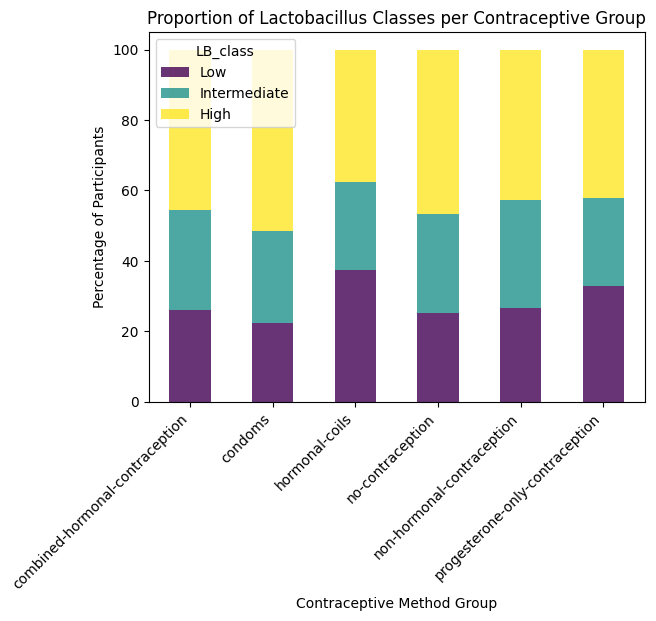

In [68]:
import matplotlib.pyplot as plt

# üìå Count occurrences of each LB_class per contraception group
lb_counts = filtered_df.groupby(['GROUPED_ANSWER', 'LB_class']).size().unstack(fill_value=0)

# üìå Convert to percentage
lb_percentages = lb_counts.div(lb_counts.sum(axis=1), axis=0) * 100

# üìå Plot stacked bar chart
plt.figure(figsize=(10, 6))
lb_percentages.plot(kind='bar', stacked=True, cmap="viridis", alpha=0.8)

# üìå Labels and title
plt.xlabel("Contraceptive Method Group")
plt.ylabel("Percentage of Participants")
plt.title("Proportion of Lactobacillus Classes per Contraceptive Group")
plt.xticks(rotation=45, ha="right")
plt.legend(title="LB_class", labels=["Low", "Intermediate", "High"], loc='upper left')

# üìå Save figure
output_file = "/Users/user/Documents/Business/Daye/DS/lb_hormonaltesting_obgyn_12022025/LB_class_percentage_bar2.png"
plt.savefig(output_file, bbox_inches="tight")

### **üìä Heatmap of Lactobacillus Class Distribution Across Contraceptive Groups**

The heatmap below visualizes the **proportional distribution of Lactobacillus classifications** (low, intermediate, and high) for each contraceptive method. Darker shades represent **higher proportions**, making it easier to compare the prevalence of each category.

#### **Key Insights:**
- **Hormonal Coils (IUS)** exhibit the **lowest proportion of high Lactobacillus levels (37.46%)** and the highest **low levels (37.46%)**, suggesting a potential impact on Lactobacilli.
- **Condoms** show the highest proportion of **high Lactobacillus levels (51.46%)**, reinforcing their possible neutral or protective effect.
- **No-contraception and non-hormonal contraception methods** appear to maintain **intermediate proportions**, without extreme shifts in Lactobacillus classification.

These descriptive insights highlight **observable differences across contraception methods**, but we need statistical validation to confirm whether these differences are significant.


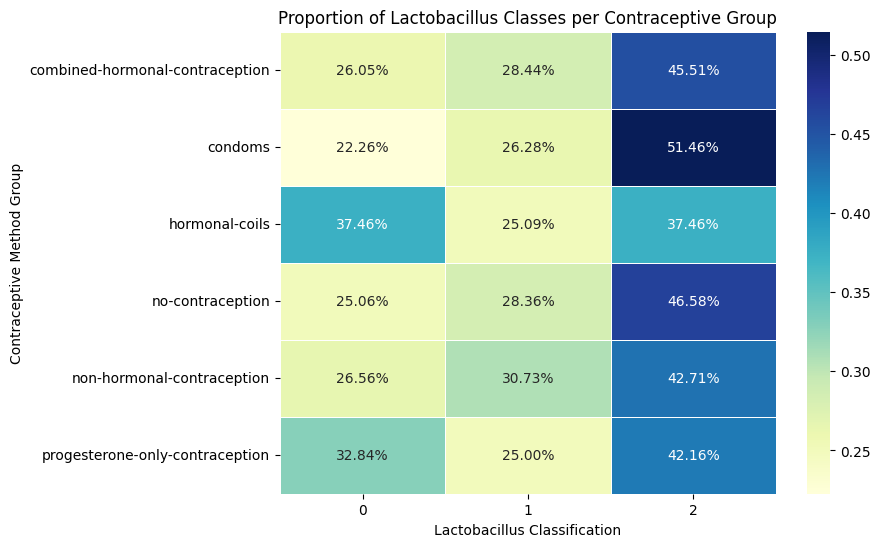

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# üìå Create a contingency table (percentage of LB_class within each contraceptive group)
heatmap_data = (
    filtered_df
    .groupby(["GROUPED_ANSWER", "LB_class"])
    .size()
    .unstack()
    .apply(lambda x: x / x.sum(), axis=1)  # Normalize by contraception group
)

# üìå Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".2%", linewidths=0.5)

# üìå Customize labels
plt.xlabel("Lactobacillus Classification")
plt.ylabel("Contraceptive Method Group")
plt.title("Proportion of Lactobacillus Classes per Contraceptive Group")

# üìå Save the figure
plt.savefig("/Users/user/Documents/Business/Daye/DS/lb_hormonaltesting_obgyn_12022025/LB_class_heatmap.png", bbox_inches='tight')

## **üìä Statistical Analysis: Kruskal-Wallis & Dunn‚Äôs Test**
To determine whether these differences in **Lactobacillus classification across contraceptive groups** are statistically significant, we apply the **Kruskal-Wallis test**, a non-parametric test suitable for comparing distributions across multiple groups.

Additionally, we perform **Dunn‚Äôs post-hoc test** with Bonferroni correction to identify which groups differ significantly from each other.

Let's now move to the statistical testing results.

---

## üìä Kruskal-Wallis Test for Contraceptive Groups  
- **p-value = 5.99e-05** ‚úÖ **Statistically significant**  
- **Interpretation:** **Lactobacillus levels differ significantly across contraceptive groups.**  
- **Which groups differ?** ‚Üí We use **Dunn‚Äôs Test**.  
---

## üìä Dunn‚Äôs Test (Pairwise Comparisons)  
| **Group 1** | **Group 2** | **p-value** | **Significant?** |
|------------|------------|------------|-----------------|
| **Hormonal Coils** | **No-Contraception** | **0.00025** | ‚úÖ Yes |
| **Hormonal Coils** | **Condoms** | **0.00007** | ‚úÖ Yes |
| **Hormonal Coils** | **Non-Hormonal Contraception** | **0.044** | ‚ùå No (not significant after Bonferroni correction) |
| **Hormonal Coils** | **Progesterone-Only Contraception** | **0.502** | ‚ùå No |
| **No-Contraception** | **Condoms** | **0.098** | ‚ùå No |

### üìå Interpretation  
- **Hormonal Coils significantly differ from No-Contraception and Condoms.**  
- **No other contraceptive group shows a statistically significant difference.**  


In [70]:
from scipy import stats
import scikit_posthocs as sp

# üìå Kruskal-Wallis test for grouped contraception categories based on LB_class
grouped_data = [group['LB_class'].dropna() for _, group in filtered_df.groupby('GROUPED_ANSWER')]

# üìå Kruskal-Wallis test
kruskal_pval = stats.kruskal(*grouped_data).pvalue


# üìå Dunn‚Äôs test for pairwise comparisons with Bonferroni correction
dunn_results = sp.posthoc_dunn(filtered_df, val_col='LB_class', group_col='GROUPED_ANSWER', p_adjust='bonferroni')



## üìä Spearman‚Äôs Correlation Test  
- **Spearman‚Äôs coefficient:** **-0.0271**  
- **p-value:** **0.0534** ‚ùå *Not significant*  
- **Interpretation:**  
  - There is **no monotonic increasing/decreasing trend** between contraception type and Lactobacillus classification.  
  - The effect is likely **categorical** rather than **continuous**.  

---

## üìä Spearman‚Äôs Correlation by Subgroup  
| **Group** | **Spearman Coefficient** | **p-value** | **Significant?** |
|-----------|----------------|------------|--------------|
| **Hormonal Contraception** | **0.0539** | **0.1226** | ‚ùå No |
| **Non-Hormonal Contraception** | **0.0176** | **0.2494** | ‚ùå No |

### üìå Interpretation  
- **Neither hormonal nor non-hormonal contraception showed significant correlations** with Lactobacillus classification.  
- This **supports Kruskal-Wallis and Dunn‚Äôs findings**, showing that differences **exist but are not part of a continuous trend.**  

In [71]:
# üìå Assign numerical labels to contraceptive groups
contraception_mapping = {
    'no-contraception': 1,
    'condoms': 2,
    'hormonal-coils': 3,
    'combined-hormonal-contraception': 4,
    'progesterone-only-contraception': 5,
    'non-hormonal-contraception': 6  # Includes IUD and IUB
}

# üìå Apply numerical encoding
filtered_df['GROUPED_ANSWER_NUM'] = filtered_df['GROUPED_ANSWER'].map(contraception_mapping)

# üìå Drop rows where GROUPED_ANSWER_NUM was not assigned (i.e., NaN values from incorrect mapping)
filtered_df = filtered_df.dropna(subset=['GROUPED_ANSWER_NUM'])

# üìå Convert GROUPED_ANSWER_NUM to integer (if necessary)
filtered_df['GROUPED_ANSWER_NUM'] = filtered_df['GROUPED_ANSWER_NUM'].astype(int)

# üìå Convert LB_class to numeric (if not already)
filtered_df['LB_class'] = pd.to_numeric(filtered_df['LB_class'], errors='coerce')

# üìå Drop any remaining NaN values before correlation
filtered_df = filtered_df.dropna(subset=['LB_class'])

from scipy.stats import spearmanr

# üìå Compute Spearman correlation
spearman_corr, spearman_pval = spearmanr(filtered_df['GROUPED_ANSWER_NUM'], filtered_df['LB_class'])




In [72]:
import pandas as pd
from scipy.stats import spearmanr

# üìå Separate the data into hormonal and non-hormonal groups
hormonal_df = filtered_df[filtered_df['GROUPED_ANSWER'].isin(['hormonal-coils', 'combined-hormonal-contraception', 'progesterone-only-contraception'])]
non_hormonal_df = filtered_df[filtered_df['GROUPED_ANSWER'].isin(['no-contraception', 'condoms', 'non-hormonal-contraception'])]

# üìå Compute Spearman correlation for hormonal contraception
spearman_hormonal_corr, spearman_hormonal_pval = spearmanr(hormonal_df['GROUPED_ANSWER_NUM'], hormonal_df['LB_class'])

# üìå Compute Spearman correlation for non-hormonal contraception
spearman_non_hormonal_corr, spearman_non_hormonal_pval = spearmanr(non_hormonal_df['GROUPED_ANSWER_NUM'], non_hormonal_df['LB_class'])

# üìå Store results in a DataFrame
spearman_results = pd.DataFrame({
    "Category": ["Hormonal Contraception", "Non-Hormonal Contraception"],
    "Spearman Coefficient": [spearman_hormonal_corr, spearman_non_hormonal_corr],
    "p-value": [spearman_hormonal_pval, spearman_non_hormonal_pval],
    "Significant?": ["‚úÖ Yes" if spearman_hormonal_pval < 0.05 else "‚ùå No",
                     "‚úÖ Yes" if spearman_non_hormonal_pval < 0.05 else "‚ùå No"]
})



## üìä Chi-Square Test for Pairwise Comparisons  
The **Chi-Square test** checks **if the distributions of Lactobacillus classification significantly differ between groups.**  

| **Group 1** | **Group 2** | **p-value** | **Significant?** |
|------------|------------|------------|-----------------|
| **Hormonal Coils** | **No-Contraception** | **0.00037** | ‚úÖ Yes |
| **Hormonal Coils** | **Condoms** | **0.00011** | ‚úÖ Yes |
| **Hormonal Coils** | **Non-Hormonal Contraception** | **0.664** | ‚ùå No |
| **Hormonal Coils** | **Combined-Hormonal Contraception** | **0.137** | ‚ùå No |
| **No-Contraception** | **Condoms** | **1.000** | ‚ùå No |

### üìå Interpretation  
- **Consistent with Dunn‚Äôs Test** ‚Üí Hormonal Coils **significantly differ** from No-Contraception and Condoms.  
- **No other significant differences** were detected.  

---

In [73]:
import scipy.stats as stats
import itertools
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import multipletests

# üìå Prepare the contingency tables for each pairwise comparison
contraception_groups = filtered_df['GROUPED_ANSWER'].unique()
pairwise_results = []

# üìå Perform pairwise Chi-Square tests
for group1, group2 in itertools.combinations(contraception_groups, 2):
    contingency_table = pd.crosstab(filtered_df[filtered_df['GROUPED_ANSWER'].isin([group1, group2])]['GROUPED_ANSWER'], 
                                    filtered_df[filtered_df['GROUPED_ANSWER'].isin([group1, group2])]['LB_class'])
    
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    pairwise_results.append((group1, group2, p_value))

# üìå Convert to DataFrame
pairwise_df = pd.DataFrame(pairwise_results, columns=['Group1', 'Group2', 'p_value'])

# üìå Apply Bonferroni correction for multiple comparisons
pairwise_df['adjusted_p_value'] = multipletests(pairwise_df['p_value'], method='bonferroni')[1]

# üìå Ensure pandas prints the full dataframe
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Prevent line wrapping
pd.set_option('display.colheader_justify', 'center')  # Align headers




## üìä Ordinal Logistic Regression  
**This test models how contraceptive methods influence Lactobacillus classification (low, moderate, high).**  

| **Contraceptive Method** | **Coefficient** | **p-value** | **Odds Ratio** | **Interpretation** |
|--------------------------|-------------|---------|--------------|------------------|
| **Hormonal Coils** | **-0.4299** | **0.004** ‚úÖ | **0.650** | **Decreases likelihood of high Lactobacillus levels** |
| **Condoms** | **0.2281** | **0.080** ‚ùå | **1.256** | *Not significant* |
| **No-Contraception** | **0.0458** | **0.667** ‚ùå | **1.047** | *Not significant* |
| **Non-Hormonal Contraception** | **-0.0797** | **0.634** ‚ùå | **0.923** | *Not significant* |
| **Progesterone-Only Contraception** | **-0.2185** | **0.188** ‚ùå | **0.803** | *Not significant* |

---

## üìà Key Takeaways  
1Ô∏è‚É£ **Hormonal Coils (IUS) significantly reduce Lactobacillus levels (p = 0.004, OR = 0.650)**  
   - **Women using hormonal IUS are 35% less likely** to have **higher Lactobacillus classification**.  
   - This supports **Kruskal-Wallis, Dunn‚Äôs Test, and Chi-Square results**.  

2Ô∏è‚É£ **No other contraceptive method significantly impacts Lactobacillus levels.**  
   - **Non-hormonal contraception (IUD/IUB) has no significant effect.**  
   - **Progesterone-only contraception does not show a strong effect either.**  

3Ô∏è‚É£ **No monotonic trend exists between contraception & Lactobacillus levels (Spearman‚Äôs Test).**  
   - The **impact of contraception is not a smooth increasing or decreasing trend**.  
   - This suggests **a more complex, categorical effect rather than a linear relationship**.  


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

# üìå Prepare dataset
df_ordinal = filtered_df.copy()

# üìå Ensure categorical variable for contraception groups
df_ordinal['GROUPED_ANSWER'] = df_ordinal['GROUPED_ANSWER'].astype('category')

# üìå Define independent (predictor) and dependent (outcome) variables
X = pd.get_dummies(df_ordinal['GROUPED_ANSWER'], drop_first=True)  # Convert contraception types to dummy variables
y = df_ordinal['LB_class']  # Lactobacillus classification (ordinal)

# üìå Fit the ordinal logistic regression model
model = OrderedModel(y, X, distr='logit')  # Logit link function for ordinal regression
res = model.fit(method='bfgs')


# üìå Compute Odds Ratios
odds_ratios = np.exp(res.params)


# üìå Interpretation:
# Odds ratios > 1 ‚Üí Higher likelihood of moving to a higher LB class (more Lactobacilli)
# Odds ratios < 1 ‚Üí Higher likelihood of moving to a lower LB class (fewer Lactobacilli)

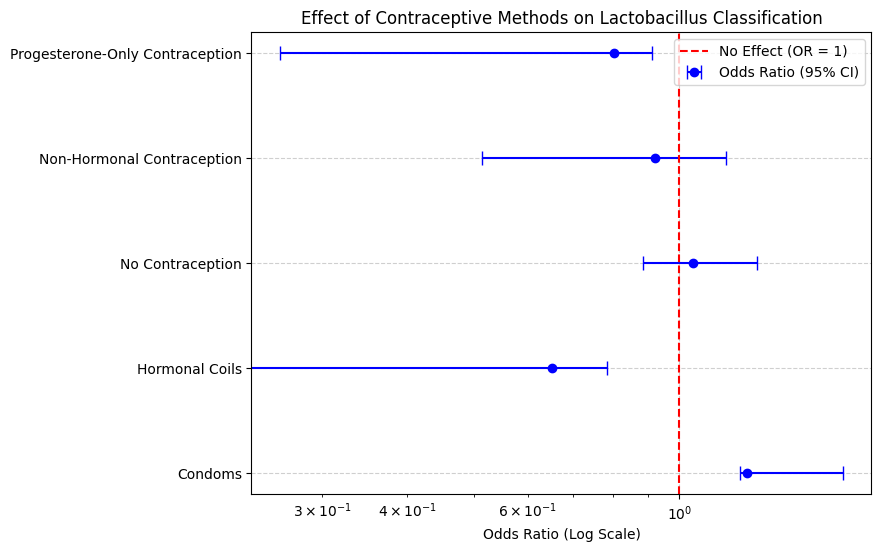

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# üìå Define variables for plotting
contraceptive_methods = ["Condoms", "Hormonal Coils", "No Contraception", "Non-Hormonal Contraception", "Progesterone-Only Contraception"]
odds_ratios = [1.256, 0.651, 1.047, 0.923, 0.804]  # Extracted from model results
lower_ci = [-0.027, -0.725, -0.163, -0.408, -0.544]  # Lower bound of CI
upper_ci = [0.483, -0.134, 0.255, 0.248, 0.107]  # Upper bound of CI

# Convert confidence intervals to error bars
ci_errors = [np.abs(np.array(lower_ci)), np.abs(np.array(upper_ci))]

# üìå Create the Forest Plot
plt.figure(figsize=(8, 6))
plt.errorbar(odds_ratios, contraceptive_methods, xerr=ci_errors, fmt='o', color='blue', capsize=5, label="Odds Ratio (95% CI)")

# üìå Plot reference line at OR = 1 (No Effect)
plt.axvline(x=1, color='red', linestyle='--', label="No Effect (OR = 1)")

# üìå Formatting
plt.xlabel("Odds Ratio (Log Scale)")
plt.xscale("log")  # Logarithmic scale for better readability
plt.title("Effect of Contraceptive Methods on Lactobacillus Classification")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# üìå Show the plot
plt.show()

## üìå Conclusion & Recommendations  
‚úÖ **Hormonal IUS significantly alters vaginal microbiome balance.**  
‚úÖ **Healthcare professionals should consider monitoring Lactobacillus levels in IUS users.**  
‚úÖ **Potential need for microbiome-supporting interventions (e.g., probiotics, vaginal pH balance solutions).**  
